#### Import packages

In [1]:
import pandas as pd
import numpy as np
import math
import joblib
import csv
import datetime

from pandas import DataFrame
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import inchi
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

#### Read data

In [2]:
df = pd.read_csv('data/activity_classes_ChEMBL24.dat', sep='\t')

##### Use data associated with the Alpha-1a adrenergic receptor

In [3]:
H3 = df[df.TargetName.eq('Histamine H3 receptor')]

In [4]:
H3.head(1)

,TargetID,TargetName,SMILES,AnalogSeriesID,pKi
1558,CHEMBL264,Histamine H3 receptor,C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,23663,7.96


In [5]:
H3.shape

(961, 5)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000271D75E5D48>]],
      dtype=object)

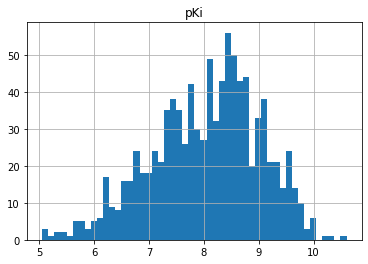

In [6]:
H3.hist('pKi', bins = 50)

#### Build a molecule record from smiles strings

In [7]:
#for index, row in H3.iterrows():
#    H3.loc[index, 'ROMol'] = Chem.MolFromSmiles(row['SMILES'])
PandasTools.AddMoleculeColumnToFrame(H3, smilesCol = "SMILES")

C:\Users\us16120\Anaconda3\lib\site-packages\rdkit\Chem\PandasTools.py:416: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,TargetID,TargetName,SMILES,AnalogSeriesID,pKi,ROMol
1558,CHEMBL264,Histamine H3 receptor,C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,23663,7.96,

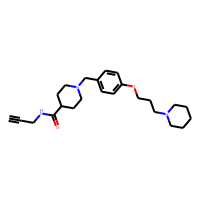

In [8]:
H3.head(1)

#### Calculate fingerprints

In [9]:
radius = 2
nBits = 1024

In [10]:
ECFP4 = [AllChem.GetMorganFingerprintAsBitVect(x, radius = radius, nBits = nBits) for x in H3['ROMol']]

In [11]:
ecfp4_names = [f'Bit_{i}' for i in range(nBits)]
ecfp4_bits = [list(l) for l in ECFP4]
H3_ecfp4 = pd.DataFrame(ecfp4_bits, index = H3.SMILES, columns = ecfp4_names)

In [12]:
H3_ecfp4.head(1)

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [13]:
H3_pKi = H3[['SMILES', 'pKi']]
H3_pKi.set_index('SMILES', inplace = True)

In [14]:
H3_pKi.head(1)

,pKi
SMILES,
C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,7.96


In [15]:
H3_Xy = H3_pKi.merge(H3_ecfp4, on = 'SMILES')

In [16]:
H3_Xy.head(1)

,pKi,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,7.96,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [17]:
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(H3.loc[1558, 'ROMol'], radius=2, bitInfo=bi)
# show 10 of the set bits:
list(fp.GetOnBits())[:10]

[2, 13, 80, 93, 102, 197, 257, 310, 322, 550]

In [18]:
from ipywidgets import interact, fixed, IntSlider
def renderFpBit(mol, bitIdx, bitInfo,fn):
    bid = bitIdx
    return(display(fn(mol, bid, bitInfo)))

In [19]:
interact(renderFpBit, bitIdx=list(bi.keys()), mol = fixed(H3.loc[1558, 'ROMol']),
         bitInfo = fixed(bi), fn = fixed(Draw.DrawMorganBit));

interactive(children=(Dropdown(description='bitIdx', options=(2, 13, 80, 93, 102, 197, 257, 310, 322, 550, 650…

#### Build training and test sets

In [20]:
X_train, X_test, y_train, y_test = train_test_split(H3_Xy.drop(['pKi'], axis = 1), H3_Xy['pKi'],
                                                   test_size = 0.2,
                                                   random_state = 42)

In [21]:
X_train.head(1)

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
CCCN1CCC(CC1)Oc2ccc(cc2)C#N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [22]:
y_train.head(1)

SMILES
CCCN1CCC(CC1)Oc2ccc(cc2)C#N    6.97
Name: pKi, dtype: float64

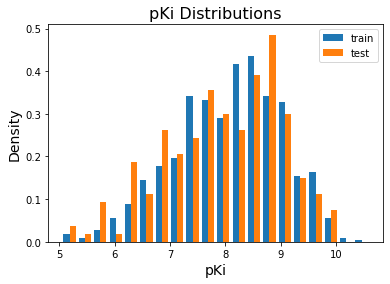

In [66]:
# create dataframe, select columns
df1x = pd.to_numeric(yTrain['pKi'])
df2x = pd.to_numeric(yTest['pKi'])
#Stack the data
plt.figure()
plt.hist([df1x,df2x], bins = 20, stacked = False, density = True)
plt.title('pKi Distributions', fontsize = 16)
plt.xlabel('pKi', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(['train', 'test'])
plt.show()

#### Random Forest Regression

##### Load libraries

In [24]:
from sklearn.ensemble import RandomForestRegressor

##### Create random forest regressor

In [25]:
regr = RandomForestRegressor(random_state=0, n_jobs=-1)

##### Train model

In [26]:
model = regr.fit(X_train, y_train)

In [27]:
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [28]:
model.score(X_train, y_train)

0.9390360688398766

In [29]:
model.score(X_test, y_test)

0.6389175810015273

In [30]:
predict_train = pd.DataFrame(model.predict(X_train).flatten())
predict_train['set'] = 'train'
predict_test = pd.DataFrame(model.predict(X_test).flatten())
predict_test['set'] = 'test'

pred = predict_train.append(predict_test)
pred.columns = ['pred', 'set']

In [31]:
pred.tail()

,pred,set
188,7.315400,test
189,7.185300,test
190,8.181700,test
191,7.987108,test
192,7.620700,test


In [32]:
pred.shape

(961, 2)

In [33]:
predictions = pred['pred'].tolist()

In [34]:
y['pred'] = predictions

y['color'] = np.where(y['set'] == 'train', '#26294d', '#f59b3f')

In [35]:
y.head(20)

,pKi,set,pred,color
SMILES,,,,
CCCN1CCC(CC1)Oc2ccc(cc2)C#N,6.97,train,7.03410,#26294d
c1cc2cccnc2c(c1)c3cc4c(nc3)nc(o4)N5CCC(CC5)N6CCCCC6,7.46,train,7.26530,#26294d
COc1cccc(n1)c2cc3c(nc2)nc(o3)N4CCC(CC4)N5CCCCC5,7.64,train,7.48340,#26294d
CC1CCCN1CCCOc2ccc(cc2)C(=O)CN3CCN(CC3)C(=O)c4ccc(cc4)F,9.22,train,8.99200,#26294d
CC(C)N1CCC(CC1)Oc2ccc3c(c2)ccc(n3)C(=O)N4CCOCC4,6.62,train,6.83200,#26294d
CC(C)N1CCC(CC1)Oc2ccc3c(c2)cc([nH]3)C(=O)N4CCC(C4)O,8.10,train,8.09430,#26294d
c1cc(ccc1CNC(=O)N(c2ccc(cc2)Br)C3CCN(CC3)C4CCCC4)F,8.15,train,7.81800,#26294d
CC1CCCN1C(CCCOC)c2ccc(cc2)c3ccc(cc3)CN4CCCCC4,8.88,train,8.78694,#26294d
CC(C)N1CCC(CC1)Oc2ccc3c(c2)cc([nH]3)C(=O)N4CCOCC4,8.30,train,8.20410,#26294d


Text(0, 0.5, 'Experimental pKi')

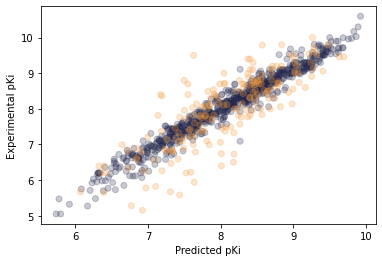

In [36]:
xPlot = y['pred']
yPlot = y['pKi']
colors = y['color']

plt.scatter(xPlot, yPlot, c = colors, alpha = 0.25)
plt.xlabel("Predicted pKi")
plt.ylabel("Experimental pKi")

#### SHAP

In [37]:
import shap

In [38]:
# load JS visualization code to notebook
shap.initjs()

In [39]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


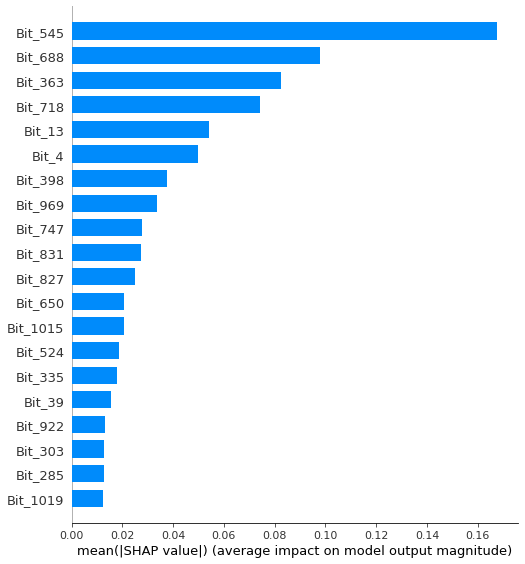

In [40]:
shap.summary_plot(shap_values, X_train, plot_type = 'bar')

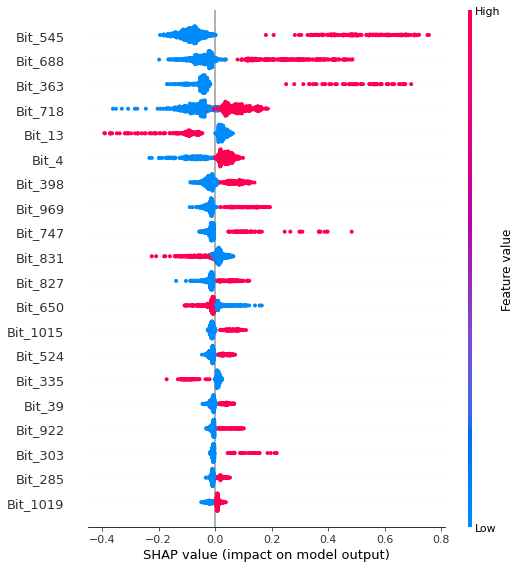

In [41]:
shap.summary_plot(shap_values, X_train)

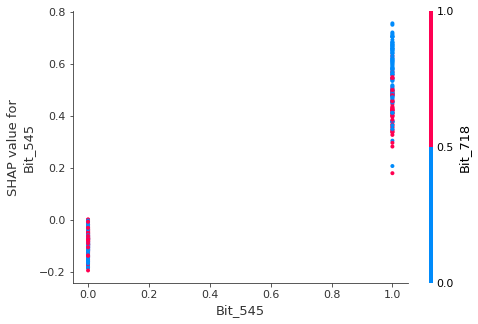

In [42]:
shap.dependence_plot("Bit_545", shap_values, X_train)

In [43]:
# Get the predictions and put them in with the test data
X_output = X_test.copy()
X_output.loc[:, 'predict'] = np.round(model.predict(X_output), 2)

# Randomly pick some observations
random_picks = np.arange(1, 193, 50)
qaz = X_output.iloc[random_picks]
qaz

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023,predict
SMILES,,,,,,,,,,,,,,,,,,,,,
CC1CCCN1CCc2ccc3c(c2)ccc(n3)c4cc(no4)C(=O)OC,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,8.93
CC1CC(CN(C1)Cc2ccc(cc2)c3ccc(cc3)CN4CC(CC(C4)C)C)C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,8.01
CC(C)NC(=O)N1CCc2ccc(cc2C1)OCCCN3CCCCC3,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.97
Cc1c(c(no1)c2ccccc2)c3ccc4cc(ccc4n3)CCN5CCCC5C,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,9.26


In [44]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(qaz)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], qaz.iloc[[j]])
    return(p)

In [55]:
y_train.mean()

8.064960937500013

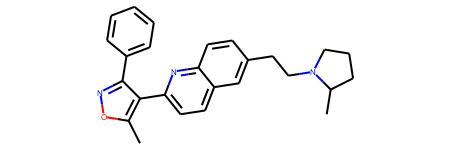

In [57]:
m = Chem.MolFromSmiles('Cc1c(c(no1)c2ccccc2)c3ccc4cc(ccc4n3)CCN5CCCC5C')
m

In [46]:
shap_plot(0)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [60]:
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius = 2, nBits = 1024, bitInfo = bi)
# show 10 of the set bits:
list(fp.GetOnBits())

[1,
 4,
 33,
 64,
 72,
 73,
 80,
 104,
 118,
 121,
 136,
 175,
 203,
 219,
 248,
 285,
 301,
 310,
 323,
 342,
 356,
 361,
 363,
 378,
 389,
 446,
 456,
 461,
 471,
 476,
 518,
 545,
 656,
 682,
 690,
 698,
 719,
 723,
 726,
 730,
 734,
 736,
 774,
 831,
 835,
 849,
 875,
 926,
 927,
 935,
 936,
 961,
 980,
 998,
 1015,
 1019]

In [59]:
interact(renderFpBit, bitIdx=list(bi.keys()), mol = fixed(m),
         bitInfo = fixed(bi), fn = fixed(Draw.DrawMorganBit));

interactive(children=(Dropdown(description='bitIdx', options=(1, 4, 33, 64, 72, 73, 80, 104, 118, 121, 136, 17…

In [47]:
shap_plot(1)

In [48]:
shap_plot(2)

In [49]:
shap_plot(3)

In [50]:
m = Chem.MolFromSmiles('Cc1c(c(no1)c2ccccc2)c3ccc4cc(ccc4n3)CCN5CCCC5C')

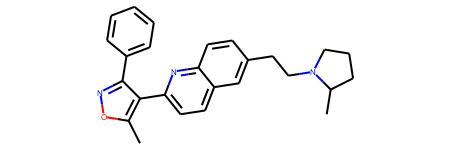

In [51]:
m

In [52]:
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius=2, nBits = 1024, bitInfo=bi)
# show 10 of the set bits:
list(fp.GetOnBits())

[1,
 4,
 33,
 64,
 72,
 73,
 80,
 104,
 118,
 121,
 136,
 175,
 203,
 219,
 248,
 285,
 301,
 310,
 323,
 342,
 356,
 361,
 363,
 378,
 389,
 446,
 456,
 461,
 471,
 476,
 518,
 545,
 656,
 682,
 690,
 698,
 719,
 723,
 726,
 730,
 734,
 736,
 774,
 831,
 835,
 849,
 875,
 926,
 927,
 935,
 936,
 961,
 980,
 998,
 1015,
 1019]

In [53]:
bi

{1: ((13, 2),),
 4: ((26, 1),),
 33: ((0, 0), (29, 0)),
 64: ((8, 1), (9, 1), (10, 1)),
 72: ((15, 2),),
 73: ((20, 1),),
 80: ((22, 0), (23, 0)),
 104: ((17, 2),),
 118: ((21, 2),),
 121: ((23, 1),),
 136: ((6, 1),),
 175: ((8, 2), (10, 2)),
 203: ((14, 2),),
 219: ((22, 1),),
 248: ((5, 1),),
 285: ((29, 1),),
 301: ((27, 1),),
 310: ((18, 2),),
 323: ((3, 1),),
 342: ((1, 2),),
 356: ((1, 0), (2, 0), (3, 0), (6, 0), (12, 0), (15, 0), (17, 0), (20, 0)),
 361: ((4, 2),),
 363: ((16, 2),),
 378: ((4, 0), (21, 0)),
 389: ((9, 2),),
 446: ((26, 2),),
 456: ((25, 1),),
 461: ((5, 2),),
 471: ((6, 2),),
 476: ((3, 2),),
 518: ((4, 1),),
 545: ((27, 2),),
 656: ((5, 0),),
 682: ((2, 2),),
 690: ((25, 2),),
 698: ((0, 1),),
 719: ((28, 2),),
 723: ((2, 1),),
 726: ((7, 1), (13, 1), (14, 1), (18, 1), (19, 1), (11, 1)),
 730: ((17, 1),),
 734: ((28, 1),),
 736: ((7, 2), (11, 2)),
 774: ((22, 2),),
 831: ((21, 1), (15, 1)),
 835: ((1, 1),),
 849: ((7, 0),
  (8, 0),
  (9, 0),
  (10, 0),
  (11, 0

In [54]:
interact(renderFpBit, bitIdx=list(bi.keys()), mol = fixed(m),
         bitInfo = fixed(bi), fn = fixed(Draw.DrawMorganBit));

interactive(children=(Dropdown(description='bitIdx', options=(1, 4, 33, 64, 72, 73, 80, 104, 118, 121, 136, 17…

In [67]:
from tpot import TPOTRegressor
tpot = TPOTRegressor(generations = 10, population_size = 50, verbosity = 2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_H3_pipeline.py')

Generation 1 - Current best internal CV score: -0.3908982668400402
Generation 2 - Current best internal CV score: -0.3868540058310413
Generation 3 - Current best internal CV score: -0.3868540058310413
Generation 4 - Current best internal CV score: -0.37717937922751776
Generation 5 - Current best internal CV score: -0.37717937922751776
Generation 6 - Current best internal CV score: -0.37717937922751776
Generation 7 - Current best internal CV score: -0.37496804902516817
Generation 8 - Current best internal CV score: -0.35988523577187326
Generation 9 - Current best internal CV score: -0.35988523577187326
Generation 10 - Current best internal CV score: -0.35988523577187326

Best pipeline: RidgeCV(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False))
-0.31703448414886826


In [68]:
tpot

TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
              disable_update_check=False, early_stop=None, generations=10,
              max_eval_time_mins=5, max_time_mins=None, memory=None,
              mutation_rate=0.9, n_jobs=1, offspring_size=None,
              periodic_checkpoint_folder=None, population_size=50,
              random_state=None, scoring=None, subsample=1.0, template=None,
              use_dask=False, verbosity=2, warm_start=False)

In [69]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [70]:
# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = H3_Xy
features = tpot_data.drop('pKi', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['pKi'], random_state = None)

# Average CV score on the training set was: -0.35988523577187326
exported_pipeline = make_pipeline(
    PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False),
    RidgeCV()
)

In [71]:
exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

In [72]:
exported_pipeline.score(training_features, training_target)

0.9929515829910854

In [73]:
exported_pipeline.score(testing_features, testing_target)

0.6448942245671135

In [76]:
len(results)

241

In [77]:
H3_Xy.shape

(961, 1025)

In [78]:
training_results = exported_pipeline.predict(training_features)
testing_results = exported_pipeline.predict(testing_features)

In [79]:
type(training_results)

numpy.ndarray

In [115]:
predict_train = pd.DataFrame(exported_pipeline.predict(training_features).flatten())
predict_train['set'] = 'train'
predict_test = pd.DataFrame(exported_pipeline.predict(testing_features).flatten())
predict_test['set'] = 'test'

pred = predict_train.append(predict_test)
pred.columns = ['pred', 'set']

In [81]:
pred.head()

,pred,set
0,9.063412,train
1,8.680474,train
2,7.128887,train
3,8.641712,train
4,7.110040,train


In [82]:
y.head()

,pKi,set,pred,color
SMILES,,,,
CCCN1CCC(CC1)Oc2ccc(cc2)C#N,6.97,train,7.0341,#26294d
c1cc2cccnc2c(c1)c3cc4c(nc3)nc(o4)N5CCC(CC5)N6CCCCC6,7.46,train,7.2653,#26294d
COc1cccc(n1)c2cc3c(nc2)nc(o3)N4CCC(CC4)N5CCCCC5,7.64,train,7.4834,#26294d
CC1CCCN1CCCOc2ccc(cc2)C(=O)CN3CCN(CC3)C(=O)c4ccc(cc4)F,9.22,train,8.9920,#26294d
CC(C)N1CCC(CC1)Oc2ccc3c(c2)ccc(n3)C(=O)N4CCOCC4,6.62,train,6.8320,#26294d


In [84]:
training_target.head()

SMILES
c1cc(ccc1CN2CCCCC2)C#CCCN3CCCCC3                           9.04
c1cc(ccc1OC2CC(NC2)C(=O)N3CCCN(CC3)C4CCC4)Cl               8.70
CCCC=CCNC(=O)OCCCc1c[nH]cn1                                7.12
CC(C)N1CCC(CC1)Oc2ccc(cc2)N3CCN(CC3=O)C(=O)c4ccc(cc4)Cl    8.60
COCCNCc1cc(no1)OCCCN2CCCCC2                                7.10
Name: pKi, dtype: float64

In [114]:
expt_train = pd.DataFrame(training_target)
expt_train['set'] = 'train'
expt_test = pd.DataFrame(testing_target)
expt_test['set'] = 'test'

expt = expt_train.append(expt_test)
expt.columns = ['expt', 'set']

In [87]:
expt.head()

,expt,set
SMILES,,
c1cc(ccc1CN2CCCCC2)C#CCCN3CCCCC3,9.04,train
c1cc(ccc1OC2CC(NC2)C(=O)N3CCCN(CC3)C4CCC4)Cl,8.70,train
CCCC=CCNC(=O)OCCCc1c[nH]cn1,7.12,train
CC(C)N1CCC(CC1)Oc2ccc(cc2)N3CCN(CC3=O)C(=O)c4ccc(cc4)Cl,8.60,train
COCCNCc1cc(no1)OCCCN2CCCCC2,7.10,train


In [93]:
type(pred['pred'])

#expt['pred'] = pred['pred']

#expt['color'] = np.where(expt['set'] == 'train', '#26294d', '#f59b3f')

pandas.core.series.Series

In [90]:
expt['expt']

SMILES
c1cc(ccc1CN2CCCCC2)C#CCCN3CCCCC3                           9.04
c1cc(ccc1OC2CC(NC2)C(=O)N3CCCN(CC3)C4CCC4)Cl               8.70
CCCC=CCNC(=O)OCCCc1c[nH]cn1                                7.12
CC(C)N1CCC(CC1)Oc2ccc(cc2)N3CCN(CC3=O)C(=O)c4ccc(cc4)Cl    8.60
COCCNCc1cc(no1)OCCCN2CCCCC2                                7.10
                                                           ... 
c1cc(ccc1C#N)OC2CCN(CC2)C3CCCCC3                           7.49
CC(C)N1CCN(CC1)C(=O)c2ccc(nc2)Oc3ccc(cc3)SC                6.64
CC1CCN(CC1)C(=O)c2ccc3cc(ccc3c2)OC4CCN(CC4)C(C)C           7.47
Cc1c(c(on1)c2ccc3cc(ccc3n2)CCN4CCCC4C)C(=O)OC              9.15
CC(=O)Nc1cc2c(cn1)nc(s2)N3CCC(CC3)N4CCCCC4                 7.28
Name: expt, Length: 961, dtype: float64

In [118]:
expt.reset_index(inplace = True)
pred.reset_index(inplace = True, drop = True)

In [119]:
expt.head()

,SMILES,expt,set
0,c1cc(ccc1CN2CCCCC2)C#CCCN3CCCCC3,9.04,train
1,c1cc(ccc1OC2CC(NC2)C(=O)N3CCCN(CC3)C4CCC4)Cl,8.70,train
2,CCCC=CCNC(=O)OCCCc1c[nH]cn1,7.12,train
3,CC(C)N1CCC(CC1)Oc2ccc(cc2)N3CCN(CC3=O)C(=O)c4c...,8.60,train
4,COCCNCc1cc(no1)OCCCN2CCCCC2,7.10,train


In [120]:
pred.head()

,pred,set
0,9.063412,train
1,8.680474,train
2,7.128887,train
3,8.641712,train
4,7.110040,train


In [121]:
qaz = pd.concat([expt, pred['pred']], axis = 1)

In [122]:
qaz.head()

,SMILES,expt,set,pred
0,c1cc(ccc1CN2CCCCC2)C#CCCN3CCCCC3,9.04,train,9.063412
1,c1cc(ccc1OC2CC(NC2)C(=O)N3CCCN(CC3)C4CCC4)Cl,8.70,train,8.680474
2,CCCC=CCNC(=O)OCCCc1c[nH]cn1,7.12,train,7.128887
3,CC(C)N1CCC(CC1)Oc2ccc(cc2)N3CCN(CC3=O)C(=O)c4c...,8.60,train,8.641712
4,COCCNCc1cc(no1)OCCCN2CCCCC2,7.10,train,7.110040


Text(0, 0.5, 'Experimental pKi')

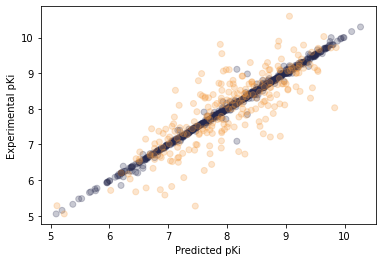

In [124]:
qaz['color'] = np.where(qaz['set'] == 'train', '#26294d', '#f59b3f')

xPlot = qaz['pred']
yPlot = qaz['expt']
colors = qaz['color']

plt.scatter(xPlot, yPlot, c = colors, alpha = 0.25)
plt.xlabel("Predicted pKi")
plt.ylabel("Experimental pKi")

In [138]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.KernelExplainer(exported_pipeline.predict, shap.sample(training_features, 1))
shap_values = explainer.shap_values(testing_features)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

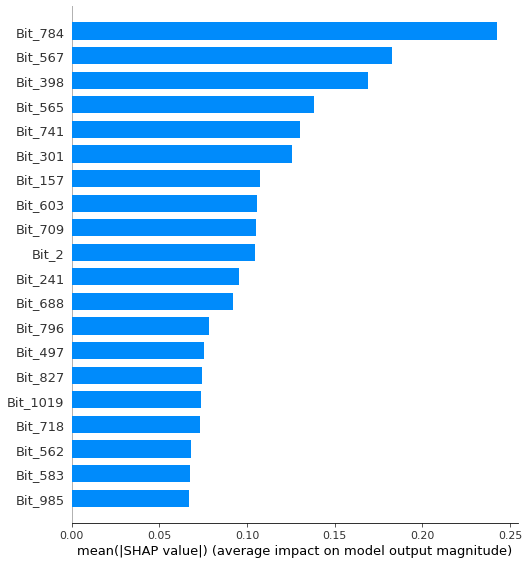

In [139]:
shap.summary_plot(shap_values, training_features, plot_type = 'bar')

In [142]:
shap_values.shape

(241, 1024)

In [143]:
training_features.shape

(720, 1024)

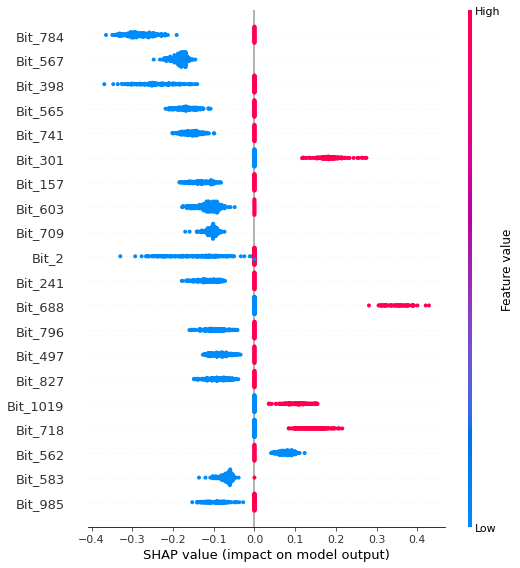

In [144]:
shap.summary_plot(shap_values, testing_features)

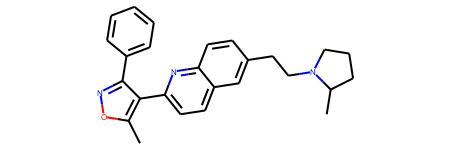

In [146]:
m = Chem.MolFromSmiles('Cc1c(c(no1)c2ccccc2)c3ccc4cc(ccc4n3)CCN5CCCC5C')
m

In [147]:
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius=2, nBits = 1024, bitInfo=bi)
# show 10 of the set bits:
list(fp.GetOnBits())

[1,
 4,
 33,
 64,
 72,
 73,
 80,
 104,
 118,
 121,
 136,
 175,
 203,
 219,
 248,
 285,
 301,
 310,
 323,
 342,
 356,
 361,
 363,
 378,
 389,
 446,
 456,
 461,
 471,
 476,
 518,
 545,
 656,
 682,
 690,
 698,
 719,
 723,
 726,
 730,
 734,
 736,
 774,
 831,
 835,
 849,
 875,
 926,
 927,
 935,
 936,
 961,
 980,
 998,
 1015,
 1019]